# Train_test Results

## Connection to GoogleDrive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Libraries installation

Run the following cells to install the libraries :

In [2]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 18.7 MB/s eta 0:00:00


In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 101.8 MB/s eta 0:00:00


In [4]:
!pip install tokenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 KB 3.4 MB/s eta 0:00:00


In [5]:
import torch, os
import datasets
import numpy as np
from torch.utils.data import DataLoader
from transformers import BertTokenizer,BertForSequenceClassification,AutoModelForSequenceClassification, AdamW
from progressbar import progressbar
from tqdm import tqdm
import seaborn as sns

## Importation of `train_test.py` file

In [6]:
%cd /content/drive/MyDrive/ANLP/projet_anlp

/content/drive/MyDrive/ANLP/projet_anlp


In [7]:
from train_test import *

## Training of the model on the different datasets of [miam](https://huggingface.co/datasets/miam)

Here are all the datasets with their number of uses that can be found on [Hugging Face](https://huggingface.co/datasets/miam) :

| Dataset name          | Language                                             | Train                    | Valid                    | Test                    |
|--------------------------|----------------------------------------------------|--------------------------|--------------------------|-------------------------|
| dihana                   | Spanish                                           | 19063                    | 2123                     |2361                     |     
| ilisten                  | Italian                                             | 1986                     | 230                      |971                      |    
| loria                    | French                                           | 8465                     | 942                      |1047                     |    
| maptask                  | English                                            | 25382                    | 5221                     |5335           |             
| vm2                      | German                                           | 25060                    | 2860                     |2855   |         


### Dataset `dihana`

In [10]:
#Load Dataset
miam= '/content/drive/MyDrive/ANLP/projet_anlp/miam.py'
dataset = datasets.load_dataset('miam','dihana')

Generating train split:   0%|          | 0/19063 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2123 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2361 [00:00<?, ? examples/s]

Dataset miam downloaded and prepared to /root/.cache/huggingface/datasets/miam/dihana/1.0.0/3cb25c5337f9e60db1dc6d90344763a6ef79d7a4ac3c5f215ce6e8afe99db26c. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
num_labels = len(set(dataset['train']['Label']))

In [12]:
#Import model et tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', return_tensors='pt')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased',num_labels=num_labels, problem_type="single_label_classification")

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

#### With weighting



---


Let's run the training and test with weighting :

In [13]:
exec_train(model,tokenizer,datasets.concatenate_datasets([dataset['train'],dataset['validation']]),True)

Map:   0%|          | 0/21186 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


tensor([1.5973, 1.6343, 1.3688, 1.1528, 1.3424, 2.5064, 2.0881, 1.7588, 1.2638,
        1.0000, 1.1031], device='cuda:0')


Training epoch 1: 100%|██████████| 663/663 [03:14<00:00,  3.40it/s, accuracy=0.92, loss=0.0085]


Map:   0%|          | 0/2361 [00:00<?, ? examples/s]

Test: 100%|██████████| 74/74 [00:06<00:00, 11.65it/s, accuracy=0.93]


test Acc: 0.9301143583227446


<Axes: >

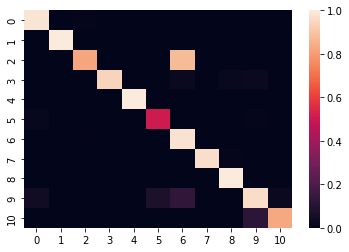

In [14]:
M = exec_test(model,tokenizer,dataset['test'])
w = np.sum(M,axis=1)
for i in range(w.shape[0]):
    if w[i] == 0:
        w[i] = 1
sns.heatmap(M/w)

##### Example



---


Let's take an example :

**Creation of a dictionary for the labels**

In [41]:
dic_label = {}
for i in dataset['test']:
  if not i[ 'Label'] in dic_label: 
    dic_label[i['Label']] = i['Dialogue_Act']

In [42]:
dic_label

{1: 'Apertura',
 9: 'Pregunta',
 3: 'Confirmacion',
 4: 'Espera',
 10: 'Respuesta',
 8: 'Nueva_consulta',
 2: 'Cierre',
 0: 'Afirmacion',
 5: 'Indefinida',
 7: 'No_entendido',
 6: 'Negacion'}

We want to see if the model finds the right label :

In [48]:
sentence = tokenizer(dataset['test']['Utterance'][9])
dic = {'input_ids' : torch.LongTensor([sentence['input_ids']]).to(torch.device('cuda')),
       'attention_mask' : torch.LongTensor([sentence['attention_mask']]).to(torch.device('cuda')), 
       'token_type_ids': torch.LongTensor([sentence['token_type_ids']]).to(torch.device('cuda'))}
output = model(**dic)

In [49]:
print('Sentence: ', dataset['test']['Utterance'][9])
print('Label number: ', dic_label[dataset['test']['Label'][9]])
print('Result: ', dic_label[int(output.logits.argmax())])

Sentence:  Ese tren sale a las 7 de la mañana y llega a las 9 y 50 de la mañana .
Label number:  Respuesta
Result:  Respuesta


We notice for the Utternance with the index 9 that the model finds the right label, which is here `Repuesta`.

#### Without weighting



---


Let's compare without the weighting :

In [50]:
exec_train(model,tokenizer,datasets.concatenate_datasets([dataset['train'],dataset['validation']]),False)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training epoch 1: 100%|██████████| 663/663 [03:12<00:00,  3.44it/s, accuracy=0.937, loss=0.00597]


Test: 100%|██████████| 74/74 [00:06<00:00, 11.68it/s, accuracy=0.95]


test Acc: 0.950021177467175


<Axes: >

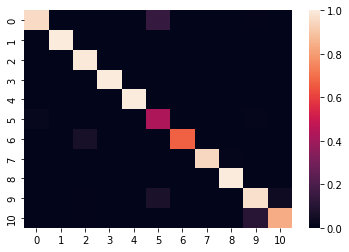

In [51]:
M = exec_test(model,tokenizer,dataset['test'])
w = np.sum(M,axis=1)
for i in range(w.shape[0]):
    if w[i] == 0:
        w[i] = 1
sns.heatmap(M/w)

##### Example



---


Let's take an example :

**Creation of a dictionary for the labels**

In [52]:
dic_label = {}
for i in dataset['test']:
  if not i[ 'Label'] in dic_label: 
    dic_label[i['Label']] = i['Dialogue_Act']

In [53]:
dic_label

{1: 'Apertura',
 9: 'Pregunta',
 3: 'Confirmacion',
 4: 'Espera',
 10: 'Respuesta',
 8: 'Nueva_consulta',
 2: 'Cierre',
 0: 'Afirmacion',
 5: 'Indefinida',
 7: 'No_entendido',
 6: 'Negacion'}

We want to see if the model finds the right label :

In [54]:
sentence = tokenizer(dataset['test']['Utterance'][9])
dic = {'input_ids' : torch.LongTensor([sentence['input_ids']]).to(torch.device('cuda')),
       'attention_mask' : torch.LongTensor([sentence['attention_mask']]).to(torch.device('cuda')), 
       'token_type_ids': torch.LongTensor([sentence['token_type_ids']]).to(torch.device('cuda'))}
output = model(**dic)

In [55]:
print('Sentence: ', dataset['test']['Utterance'][9])
print('Label number: ', dic_label[dataset['test']['Label'][9]])
print('Result: ', dic_label[int(output.logits.argmax())])

Sentence:  Ese tren sale a las 7 de la mañana y llega a las 9 y 50 de la mañana .
Label number:  Respuesta
Result:  Respuesta


We notice for the Utternance with the index 9 that the model finds the right label, which is here `Repuesta`.

### Dataset `ilisten`

In [56]:
#Load Dataset
miam= '/content/drive/MyDrive/ANLP/projet_anlp/miam.py'
dataset = datasets.load_dataset('miam','ilisten')

Generating train split:   0%|          | 0/1986 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/230 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/971 [00:00<?, ? examples/s]

Dataset miam downloaded and prepared to /root/.cache/huggingface/datasets/miam/ilisten/1.0.0/3cb25c5337f9e60db1dc6d90344763a6ef79d7a4ac3c5f215ce6e8afe99db26c. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [57]:
num_labels = len(set(dataset['train']['Label']))

In [58]:
#Import model et tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', return_tensors='pt')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased',num_labels=num_labels, problem_type="single_label_classification")


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

#### With weighting

---


Let's run the training and test with weighting :

In [59]:
exec_train(model,tokenizer,datasets.concatenate_datasets([dataset['train'],dataset['validation']]),True)

Map:   0%|          | 0/2216 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


tensor([1.5694, 1.1515, 1.5211, 1.4302, 1.3847, 1.0631, 1.2911, 1.4651, 1.5383,
        1.0909, 1.0000, 1.7832, 1.4343, 1.0084, 1.7368], device='cuda:0')



Training epoch 1: 100%|██████████| 70/70 [00:20<00:00,  3.34it/s, accuracy=0.505, loss=0.053]


Map:   0%|          | 0/971 [00:00<?, ? examples/s]


Test: 100%|██████████| 31/31 [00:02<00:00, 10.98it/s, accuracy=0.653]


test Acc: 0.6529351184346035


<Axes: >

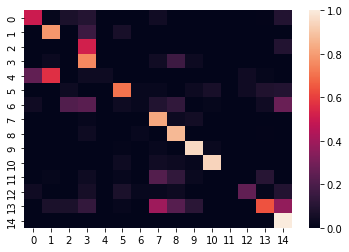

In [60]:
M = exec_test(model,tokenizer,dataset['test'])
w = np.sum(M,axis=1)
for i in range(w.shape[0]):
    if w[i] == 0:
        w[i] = 1
sns.heatmap(M/w)

##### Example



---


Let's take an example :

**Creation of a dictionary for the labels**

In [62]:
dic_label = {}
for i in dataset['test']:
  if not i[ 'Label'] in dic_label: 
    dic_label[i['Label']] = i['Dialogue_Act']

In [63]:
dic_label

{8: 'OPENING',
 13: 'STATEMENT',
 10: 'QUESTION',
 4: 'GENERIC-ANSWER',
 7: 'OFFER-GIVE-INFO',
 5: 'INFO-REQUEST',
 9: 'PERSUASION-SUGGEST',
 6: 'KIND-ATTITUDE_SMALL-TALK',
 3: 'ENCOURAGE-SORRY',
 2: 'CLOSING',
 12: 'SOLICITATION-REQ_CLARIFICATION',
 1: 'ANSWER',
 11: 'REJECT',
 0: 'AGREE',
 14: 'TALK-ABOUT-SELF'}

We want to see if the model finds the right label :

In [64]:
sentence = tokenizer(dataset['test']['Utterance'][9])
dic = {'input_ids' : torch.LongTensor([sentence['input_ids']]).to(torch.device('cuda')),
       'attention_mask' : torch.LongTensor([sentence['attention_mask']]).to(torch.device('cuda')), 
       'token_type_ids': torch.LongTensor([sentence['token_type_ids']]).to(torch.device('cuda'))}
output = model(**dic)

In [65]:
print('Sentence: ', dataset['test']['Utterance'][9])
print('Label number: ', dic_label[dataset['test']['Label'][9]])
print('Result: ', dic_label[int(output.logits.argmax())])

Sentence:  penso che la mia dieta necessiti di un regime più regolare
Label number:  STATEMENT
Result:  STATEMENT


We notice for the Utternance with the index 9 that the model finds the right label, which is here `STATEMENT`.

#### Without weighting


---


Let's compare without the weighting :

In [66]:
exec_train(model,tokenizer,datasets.concatenate_datasets([dataset['train'],dataset['validation']]),False)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

Training epoch 1: 100%|██████████| 70/70 [00:20<00:00,  3.41it/s, accuracy=0.768, loss=0.0242]



Test: 100%|██████████| 31/31 [00:02<00:00, 11.11it/s, accuracy=0.788]


test Acc: 0.787847579814624


<Axes: >

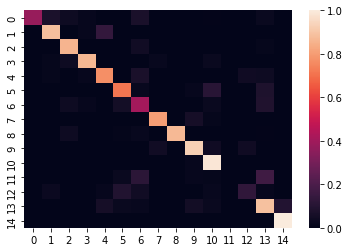

In [67]:
M = exec_test(model,tokenizer,dataset['test'])
w = np.sum(M,axis=1)
for i in range(w.shape[0]):
    if w[i] == 0:
        w[i] = 1
sns.heatmap(M/w)

##### Example



---


Let's take an example :

**Creation of a dictionary for the labels**

In [68]:
dic_label = {}
for i in dataset['test']:
  if not i[ 'Label'] in dic_label: 
    dic_label[i['Label']] = i['Dialogue_Act']

In [69]:
dic_label

{8: 'OPENING',
 13: 'STATEMENT',
 10: 'QUESTION',
 4: 'GENERIC-ANSWER',
 7: 'OFFER-GIVE-INFO',
 5: 'INFO-REQUEST',
 9: 'PERSUASION-SUGGEST',
 6: 'KIND-ATTITUDE_SMALL-TALK',
 3: 'ENCOURAGE-SORRY',
 2: 'CLOSING',
 12: 'SOLICITATION-REQ_CLARIFICATION',
 1: 'ANSWER',
 11: 'REJECT',
 0: 'AGREE',
 14: 'TALK-ABOUT-SELF'}

We want to see if the model finds the right label :

In [70]:
sentence = tokenizer(dataset['test']['Utterance'][9])
dic = {'input_ids' : torch.LongTensor([sentence['input_ids']]).to(torch.device('cuda')),
       'attention_mask' : torch.LongTensor([sentence['attention_mask']]).to(torch.device('cuda')), 
       'token_type_ids': torch.LongTensor([sentence['token_type_ids']]).to(torch.device('cuda'))}
output = model(**dic)

In [71]:
print('Sentence: ', dataset['test']['Utterance'][9])
print('Label number: ', dic_label[dataset['test']['Label'][9]])
print('Result: ', dic_label[int(output.logits.argmax())])

Sentence:  penso che la mia dieta necessiti di un regime più regolare
Label number:  STATEMENT
Result:  STATEMENT


We notice for the Utternance with the index 9 that the model finds the right label, which is here `STATEMENT`.

### Dataset `loria`

In [72]:
#Load Dataset
miam= '/content/drive/MyDrive/ANLP/projet_anlp/miam.py'
dataset = datasets.load_dataset('miam','loria')

Generating train split:   0%|          | 0/8465 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/942 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1047 [00:00<?, ? examples/s]

Dataset miam downloaded and prepared to /root/.cache/huggingface/datasets/miam/loria/1.0.0/3cb25c5337f9e60db1dc6d90344763a6ef79d7a4ac3c5f215ce6e8afe99db26c. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [73]:
num_labels = len(set(dataset['train']['Label']))

In [74]:
#Import model et tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', return_tensors='pt')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased',num_labels=num_labels, problem_type="single_label_classification")


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

#### With weighting

---


Let's run the training and test with weighting :

In [75]:
exec_train(model,tokenizer,datasets.concatenate_datasets([dataset['train'],dataset['validation']]),True)

Map:   0%|          | 0/9407 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


tensor([1.4448, 1.0092, 2.4286, 2.1224, 2.2651, 1.1122, 1.7250, 1.0000, 4.2448,
        2.1753, 2.5944, 2.7512, 2.9711, 2.2214, 2.2728, 4.6977, 2.1061, 1.6950,
        1.6241, 1.7153, 2.2214, 1.0976, 4.4428, 3.1821, 3.3218, 3.4987, 3.4345,
        3.3218, 3.0015, 2.5110, 1.3183], device='cuda:0')


Training epoch 1: 100%|██████████| 294/294 [01:26<00:00,  3.41it/s, accuracy=0.708, loss=0.0454]


Map:   0%|          | 0/1047 [00:00<?, ? examples/s]

Test: 100%|██████████| 33/33 [00:02<00:00, 11.52it/s, accuracy=0.766]


test Acc: 0.7659980897803247


<Axes: >

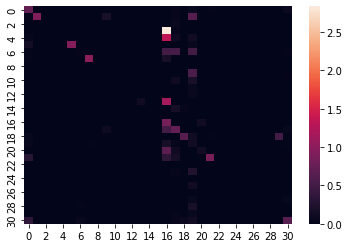

In [76]:
M = exec_test(model,tokenizer,dataset['test'])
w = np.sum(M,axis=1)
for i in range(w.shape[0]):
    if w[i] == 0:
        w[i] = 1
sns.heatmap(M/w)

##### Example



---


Let's take an example :

**Creation of a dictionary for the labels**

In [77]:
dic_label = {}
for i in dataset['test']:
  if not i[ 'Label'] in dic_label: 
    dic_label[i['Label']] = i['Dialogue_Act']

In [78]:
dic_label

{5: 'greet',
 1: 'ask',
 17: 'next_step',
 7: 'inform',
 21: 'quit',
 30: 'yes',
 9: 'inform_job',
 28: 'todo_failure',
 29: 'todo_irreparable',
 16: 'manufacturing_reqs',
 18: 'no',
 0: 'ack',
 10: 'inform_material_space',
 6: 'help',
 4: 'first_step',
 3: 'find_plans',
 12: 'informer_decoration',
 13: 'informer_elcomps',
 23: 'security_policies',
 14: 'informer_end_manufacturing',
 11: 'informer_conditioner',
 27: 'studies_job',
 25: 'staff_job',
 19: 'other',
 2: 'find_mold',
 20: 'quality_control'}

We want to see if the model finds the right label :

In [79]:
sentence = tokenizer(dataset['test']['Utterance'][9])
dic = {'input_ids' : torch.LongTensor([sentence['input_ids']]).to(torch.device('cuda')),
       'attention_mask' : torch.LongTensor([sentence['attention_mask']]).to(torch.device('cuda')), 
       'token_type_ids': torch.LongTensor([sentence['token_type_ids']]).to(torch.device('cuda'))}
output = model(**dic)

In [80]:
print('Sentence: ', dataset['test']['Utterance'][9])
print('Label number: ', dic_label[dataset['test']['Label'][9]])
print('Result: ', dic_label[int(output.logits.argmax())])

Sentence:  je peux vous renseigner sur cet endroit?
Label number:  ask
Result:  ask


We notice for the Utternance with the index 9 that the model finds the right label, which is here `ask`.

#### Without weighting

---


Let's compare without the weighting :

In [81]:
exec_train(model,tokenizer,datasets.concatenate_datasets([dataset['train'],dataset['validation']]),False)

Training epoch 1: 100%|██████████| 294/294 [01:26<00:00,  3.42it/s, accuracy=0.777, loss=0.0253]


Test: 100%|██████████| 33/33 [00:02<00:00, 11.88it/s, accuracy=0.802]


test Acc: 0.8022922636103151


<Axes: >

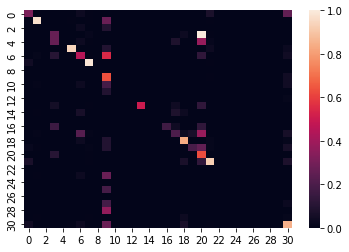

In [82]:
M = exec_test(model,tokenizer,dataset['test'])
w = np.sum(M,axis=1)
for i in range(w.shape[0]):
    if w[i] == 0:
        w[i] = 1
sns.heatmap(M/w)

##### Example



---


Let's take an example :

**Creation of a dictionary for the labels**

In [83]:
dic_label = {}
for i in dataset['test']:
  if not i[ 'Label'] in dic_label: 
    dic_label[i['Label']] = i['Dialogue_Act']

In [84]:
dic_label

{5: 'greet',
 1: 'ask',
 17: 'next_step',
 7: 'inform',
 21: 'quit',
 30: 'yes',
 9: 'inform_job',
 28: 'todo_failure',
 29: 'todo_irreparable',
 16: 'manufacturing_reqs',
 18: 'no',
 0: 'ack',
 10: 'inform_material_space',
 6: 'help',
 4: 'first_step',
 3: 'find_plans',
 12: 'informer_decoration',
 13: 'informer_elcomps',
 23: 'security_policies',
 14: 'informer_end_manufacturing',
 11: 'informer_conditioner',
 27: 'studies_job',
 25: 'staff_job',
 19: 'other',
 2: 'find_mold',
 20: 'quality_control'}

We want to see if the model finds the right label :

In [85]:
sentence = tokenizer(dataset['test']['Utterance'][9])
dic = {'input_ids' : torch.LongTensor([sentence['input_ids']]).to(torch.device('cuda')),
       'attention_mask' : torch.LongTensor([sentence['attention_mask']]).to(torch.device('cuda')), 
       'token_type_ids': torch.LongTensor([sentence['token_type_ids']]).to(torch.device('cuda'))}
output = model(**dic)

In [86]:
print('Sentence: ', dataset['test']['Utterance'][9])
print('Label number: ', dic_label[dataset['test']['Label'][9]])
print('Result: ', dic_label[int(output.logits.argmax())])

Sentence:  je peux vous renseigner sur cet endroit?
Label number:  ask
Result:  ask


We notice for the Utternance with the index 9 that the model finds the right label, which is here `ask`.

### Dataset `maptask`

In [87]:
#Load Dataset
miam= '/content/drive/MyDrive/ANLP/projet_anlp/miam.py'
dataset = datasets.load_dataset('miam','maptask')

Generating train split:   0%|          | 0/25382 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5221 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5335 [00:00<?, ? examples/s]

Dataset miam downloaded and prepared to /root/.cache/huggingface/datasets/miam/maptask/1.0.0/3cb25c5337f9e60db1dc6d90344763a6ef79d7a4ac3c5f215ce6e8afe99db26c. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [88]:
num_labels = len(set(dataset['train']['Label']))

In [89]:
#Import model et tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', return_tensors='pt')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased',num_labels=num_labels, problem_type="single_label_classification")


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

#### With weighting

---


Let's run the training and test with weighting :

In [90]:
exec_train(model,tokenizer,datasets.concatenate_datasets([dataset['train'],dataset['validation']]),True)

Map:   0%|          | 0/30603 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


tensor([1.0000, 1.3199, 1.2670, 1.4787, 1.2596, 1.0711, 1.6285, 1.3283, 1.2698,
        1.5738, 1.5614, 1.1391], device='cuda:0')


Training epoch 1: 100%|██████████| 957/957 [04:36<00:00,  3.46it/s, accuracy=0.565, loss=0.0412]


Test: 100%|██████████| 167/167 [00:14<00:00, 11.41it/s, accuracy=0.602]


test Acc: 0.6016869728209935


<Axes: >

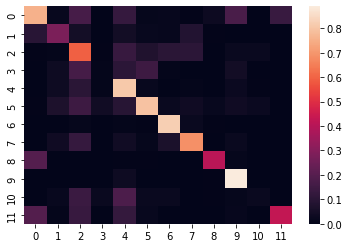

In [102]:
M = exec_test(model,tokenizer,dataset['test'])
w = np.sum(M,axis=1)
for i in range(w.shape[0]):
    if w[i] == 0:
        w[i] = 1
sns.heatmap(M/w)

##### Example



---


Let's take an example :

**Creation of a dictionary for the labels**

In [103]:
dic_label = {}
for i in dataset['test']:
  if not i[ 'Label'] in dic_label: 
    dic_label[i['Label']] = i['Dialogue_Act']

In [104]:
dic_label

{5: 'instruct',
 6: 'query_w',
 10: 'reply_w',
 0: 'acknowledge',
 3: 'clarify',
 11: 'reply_y',
 4: 'explain',
 2: 'check',
 7: 'query_yn',
 9: 'reply_n',
 8: 'ready',
 1: 'align'}

We want to see if the model finds the right label :

In [105]:
sentence = tokenizer(dataset['test']['Utterance'][9])
dic = {'input_ids' : torch.LongTensor([sentence['input_ids']]).to(torch.device('cuda')),
       'attention_mask' : torch.LongTensor([sentence['attention_mask']]).to(torch.device('cuda')), 
       'token_type_ids': torch.LongTensor([sentence['token_type_ids']]).to(torch.device('cuda'))}
output = model(**dic)

In [106]:
print('Sentence: ', dataset['test']['Utterance'][9])
print('Label number: ', dic_label[dataset['test']['Label'][9]])
print('Result: ', dic_label[int(output.logits.argmax())])

Sentence:  it's underneath the rope bridge
Label number:  reply_y
Result:  explain


We notice for the Utternance with the index 9 that the model doesn't find the right label. The right label is `reply_y` and it detects `explain`

#### Without weighting

---


Let's compare without the weighting :

In [107]:
exec_train(model,tokenizer,datasets.concatenate_datasets([dataset['train'],dataset['validation']]),False)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training epoch 1: 100%|██████████| 957/957 [04:36<00:00,  3.46it/s, accuracy=0.606, loss=0.0361]


Test: 100%|██████████| 167/167 [00:14<00:00, 11.35it/s, accuracy=0.635]


test Acc: 0.6354264292408622


<Axes: >

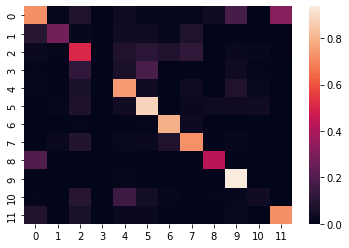

In [114]:
M = exec_test(model,tokenizer,dataset['test'])
w = np.sum(M,axis=1)
for i in range(w.shape[0]):
    if w[i] == 0:
        w[i] = 1
sns.heatmap(M/w)

##### Example



---


Let's take an example :

**Creation of a dictionary for the labels**

In [115]:
dic_label = {}
for i in dataset['test']:
  if not i[ 'Label'] in dic_label: 
    dic_label[i['Label']] = i['Dialogue_Act']

In [116]:
dic_label

{5: 'instruct',
 6: 'query_w',
 10: 'reply_w',
 0: 'acknowledge',
 3: 'clarify',
 11: 'reply_y',
 4: 'explain',
 2: 'check',
 7: 'query_yn',
 9: 'reply_n',
 8: 'ready',
 1: 'align'}

We want to see if the model finds the right label :

In [129]:
sentence = tokenizer(dataset['test']['Utterance'][9])
dic = {'input_ids' : torch.LongTensor([sentence['input_ids']]).to(torch.device('cuda')),
       'attention_mask' : torch.LongTensor([sentence['attention_mask']]).to(torch.device('cuda')), 
       'token_type_ids': torch.LongTensor([sentence['token_type_ids']]).to(torch.device('cuda'))}
output = model(**dic)

In [130]:
print('Sentence: ', dataset['test']['Utterance'][9])
print('Label number: ', dic_label[dataset['test']['Label'][9]])
print('Result: ', dic_label[int(output.logits.argmax())])

Sentence:  it's underneath the rope bridge
Label number:  reply_y
Result:  explain


We notice for the Utternance with the index 9 that the model doesn't find the right label. The right label is `reply_y` and it detects `explain`.

### Dataset `vm2`

In [132]:
#Load Dataset
miam= '/content/drive/MyDrive/ANLP/projet_anlp/miam.py'
dataset = datasets.load_dataset('miam','vm2')

  0%|          | 0/3 [00:00<?, ?it/s]

In [133]:
num_labels = len(set(dataset['train']['Label']))

In [134]:
#Import model et tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', return_tensors='pt')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased',num_labels=num_labels, problem_type="single_label_classification")


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

#### With weighting

---


Let's run the training and test with weighting :

In [135]:
exec_train(model,tokenizer,datasets.concatenate_datasets([dataset['train'],dataset['validation']]),True)

Map:   0%|          | 0/27920 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


tensor([1.1076, 1.2211, 1.8017, 1.9157, 1.7947, 1.7888, 1.9383, 2.0333, 1.5246,
        2.8136, 1.8866, 2.4202, 2.2863, 2.0259, 1.0769, 1.6281, 2.5805, 1.0000,
        1.4508, 2.6316, 1.4840, 2.9274, 2.2391, 2.0064, 1.6468, 1.9456, 1.5827,
        2.5017, 1.6379, 1.0325, 2.2017], device='cuda:0')


Training epoch 1: 100%|██████████| 873/873 [04:12<00:00,  3.46it/s, accuracy=0.369, loss=0.0719]


Map:   0%|          | 0/2855 [00:00<?, ? examples/s]

Test: 100%|██████████| 90/90 [00:07<00:00, 11.71it/s, accuracy=0.417]


test Acc: 0.41716287215411557


<Axes: >

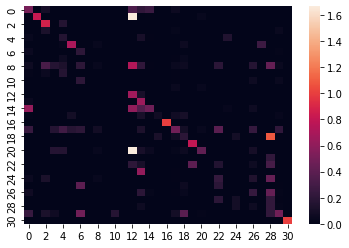

In [136]:
M = exec_test(model,tokenizer,dataset['test'])
w = np.sum(M,axis=1)
for i in range(w.shape[0]):
    if w[i] == 0:
        w[i] = 1
sns.heatmap(M/w)

##### Example



---


Let's take an example :

**Creation of a dictionary for the labels**

In [137]:
dic_label = {}
for i in dataset['test']:
  if not i[ 'Label'] in dic_label: 
    dic_label[i['Label']] = i['Dialogue_Act']

In [138]:
dic_label

{22: 'POLITENESS_FORMULA',
 26: 'REQUEST_COMMENT',
 14: 'FEEDBACK_POSITIVE',
 17: 'INFORM',
 20: 'NOT_CLASSIFIABLE',
 30: 'THANK',
 18: 'INIT',
 1: 'BACKCHANNEL',
 24: 'REQUEST',
 8: 'DELIBERATE',
 29: 'SUGGEST',
 15: 'GIVE_REASON',
 23: 'REJECT',
 25: 'REQUEST_CLARIFY',
 10: 'EXCLUDE',
 0: 'ACCEPT',
 13: 'FEEDBACK_NEGATIVE',
 3: 'CLARIFY',
 6: 'CONFIRM',
 5: 'COMMIT',
 27: 'REQUEST_COMMIT',
 9: 'DEVIATE_SCENARIO',
 2: 'BYE',
 4: 'CLOSE',
 11: 'EXPLAINED_REJECT',
 16: 'GREET',
 19: 'INTRODUCE',
 28: 'REQUEST_SUGGEST',
 12: 'FEEDBACK',
 7: 'DEFER',
 21: 'OFFER'}

We want to see if the model finds the right label :

In [139]:
sentence = tokenizer(dataset['test']['Utterance'][9])
dic = {'input_ids' : torch.LongTensor([sentence['input_ids']]).to(torch.device('cuda')),
       'attention_mask' : torch.LongTensor([sentence['attention_mask']]).to(torch.device('cuda')), 
       'token_type_ids': torch.LongTensor([sentence['token_type_ids']]).to(torch.device('cuda'))}
output = model(**dic)

In [140]:
print('Sentence: ', dataset['test']['Utterance'][9])
print('Label number: ', dic_label[dataset['test']['Label'][9]])
print('Result: ', dic_label[int(output.logits.argmax())])

Sentence:  wir dürfen
Label number:  NOT_CLASSIFIABLE
Result:  NOT_CLASSIFIABLE


We notice for the Utternance with the index 9 that the model finds the right label, which is here `NOT_CLASSIFIABLE`.

#### Without weighting

---


Let's compare without the weighting :

In [141]:
exec_train(model,tokenizer,datasets.concatenate_datasets([dataset['train'],dataset['validation']]),False)

Training epoch 1: 100%|██████████| 873/873 [04:12<00:00,  3.46it/s, accuracy=0.632, loss=0.0365]


Test: 100%|██████████| 90/90 [00:07<00:00, 11.48it/s, accuracy=0.565]


test Acc: 0.5646234676007005


<Axes: >

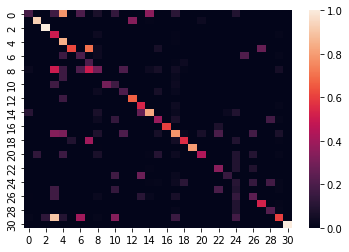

In [148]:
M = exec_test(model,tokenizer,dataset['test'])
w = np.sum(M,axis=1)
for i in range(w.shape[0]):
    if w[i] == 0:
        w[i] = 1
sns.heatmap(M/w)

##### Example



---


Let's take an example :

**Creation of a dictionary for the labels**

In [149]:
dic_label = {}
for i in dataset['test']:
  if not i[ 'Label'] in dic_label: 
    dic_label[i['Label']] = i['Dialogue_Act']

In [150]:
dic_label

{22: 'POLITENESS_FORMULA',
 26: 'REQUEST_COMMENT',
 14: 'FEEDBACK_POSITIVE',
 17: 'INFORM',
 20: 'NOT_CLASSIFIABLE',
 30: 'THANK',
 18: 'INIT',
 1: 'BACKCHANNEL',
 24: 'REQUEST',
 8: 'DELIBERATE',
 29: 'SUGGEST',
 15: 'GIVE_REASON',
 23: 'REJECT',
 25: 'REQUEST_CLARIFY',
 10: 'EXCLUDE',
 0: 'ACCEPT',
 13: 'FEEDBACK_NEGATIVE',
 3: 'CLARIFY',
 6: 'CONFIRM',
 5: 'COMMIT',
 27: 'REQUEST_COMMIT',
 9: 'DEVIATE_SCENARIO',
 2: 'BYE',
 4: 'CLOSE',
 11: 'EXPLAINED_REJECT',
 16: 'GREET',
 19: 'INTRODUCE',
 28: 'REQUEST_SUGGEST',
 12: 'FEEDBACK',
 7: 'DEFER',
 21: 'OFFER'}

We want to see if the model finds the right label :

In [151]:
sentence = tokenizer(dataset['test']['Utterance'][9])
dic = {'input_ids' : torch.LongTensor([sentence['input_ids']]).to(torch.device('cuda')),
       'attention_mask' : torch.LongTensor([sentence['attention_mask']]).to(torch.device('cuda')), 
       'token_type_ids': torch.LongTensor([sentence['token_type_ids']]).to(torch.device('cuda'))}
output = model(**dic)

In [152]:
print('Sentence: ', dataset['test']['Utterance'][9])
print('Label number: ', dic_label[dataset['test']['Label'][9]])
print('Result: ', dic_label[int(output.logits.argmax())])

Sentence:  wir dürfen
Label number:  NOT_CLASSIFIABLE
Result:  NOT_CLASSIFIABLE


We notice for the Utternance with the index 9 that the model finds the right label, which is here `NOT_CLASSIFIABLE`.

## Results

Here are the different results obtained for each dataset with the multilingual m-BERT model. We use here the metric `accuracy` (in %):


| Dataset name          | Language                                             | With weighting                |                         | Without weighting||
|--------------------------|----------------------------------------------------|--------------------------|--------------------------|-------------------------- | --------------------------|
|          |                                              | Train & Valid                 | Test                    |Train & Valid                 | Test                    |
|--------------------------|----------------------------------------------------|--------------------------|--------------------------|-------------------------- | --------------------------|
| dihana                   | Spanish                                           | 91.5                                   |94.7 |  93.9|93.5|   
| ilisten                  | Italian                                             | 54.4                     | 75.3                     |    78.3 |80.3|
| loria                    | French                                           | 70.9                             |83.5 |81.6|84.5                     |    
| maptask                  | English                                            | 55.5                            |60.1        |    60.2|       61.3|  
| vm2                      | German                                           | 57.6                           |54.9   |   76.7|56.2|
|--------------------------|----------------------------------------------------|--------------------------|--------------------------|--------------------------|--------------------------|
| **Total**                      |                                            | **66.0**                       |**73.7**   | **78.1**  | **75.2**|
      
   


We only make one `epoch` for training our model, which avoids overfitting. In this case the `valid set` is not needed and we group the `train` and `valid` sets for training.



---
If we compare our results to the m-BERT model from the [original paper](https://aclanthology.org/2021.emnlp-main.656.pdf), we find similar results, with an average of **73.7% accuracy** with weighting and **75.2% accuracy** with weighting for our model **vs.** **73.8%** for the original paper model